# Modeling Consumer Activity with a Modified Maxwell–Boltzmann Distribution

This notebook reproduces the main steps of the modeling procedure described in our paper:
"Study of the relationship between individual consumer behavior and macroeconomic trends."

It demonstrates:
1. Preprocessing of banking transaction data  
2. Construction of the consumer activity metric  
3. Fitting of the modified and classical Maxwell–Boltzmann distributions  
4. Evaluation of model quality using statistical metrics  
5. Comparison across datasets and model variants

Data used: 1st dataset with 10K clients(dataset_1)

Model variants: Modified and Non-Modified (NM)

# Description of the first data set

The dataset under study is data on 19262668 transactions of 10000 bank clients. The observation period is from 01/01/2018 to 08/15/2022.

Each row corresponds to one client and includes the following columns:
- `client` : Client identifier (discrete numeric).
- `card` : Client's payment card identifier (discrete numeric).
- `date` : Transaction date (continuous numeric, date format).
- `amt` : Amount spent (continuous numeric).
- `mcc` : Merchant category code (discrete numeric).
- `group` : The group the purchase belongs to (categorical). Examples: 'food', 'travel', 'fun'.
- `value` : Basic value category (categorical):
  - `survival`: 'food', 'outfit', 'health', 'dwelling'.
  - `socialization`: 'travel', 'nonfood', 'telecom', 'misc', 'remote'.
  - `self_realization` : 'fun', 'kids', 'beauty', 'charity'.

### Data preprocessing

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from statsmodels.tsa.seasonal import STL

from model import *

In [2]:
selected_dataset = 'dataset_1'

In [3]:
# Downloading data
df = pd.read_csv('../Data/dataset10k.csv')

In [4]:
df.head()

,client,card,date,amt,mcc,group,value
0,390989,3048567,2018-01-01,878.0,5814,food,survival
1,1309946,3226559,2018-01-01,249.0,5411,food,survival
2,1386278,2715990,2018-01-01,50.0,5499,food,survival
3,475694,2884069,2018-01-01,2564.0,5941,fun,self_realization
4,710293,3396065,2018-01-01,464.9,5814,food,survival


In [5]:
df['date'] = pd.to_datetime(df['date'])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16174410 entries, 0 to 16174409
Data columns (total 7 columns):
 #   Column  Dtype         
---  ------  -----         
 0   client  int64         
 1   card    int64         
 2   date    datetime64[ns]
 3   amt     float64       
 4   mcc     int64         
 5   group   object        
 6   value   object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 863.8+ MB


In [7]:
# Main statistics
stats = {
    'Mean': df['amt'].mean(),
    'Median': df['amt'].median(),
    'Standard deviation': df['amt'].std(),
    'Min': df['amt'].min(),
    'Max': df['amt'].max(),
    '25% quantile': df['amt'].quantile(0.25),
    '75% quantile': df['amt'].quantile(0.75),
    'Coefficient of variation': df['amt'].std() / df['amt'].mean()
}
print(pd.DataFrame.from_dict(stats, orient='index', columns=['Value']))

                                 Value
Mean                      8.780405e+02
Median                    3.564000e+02
Standard deviation        3.586286e+03
Min                       1.000000e-02
Max                       2.350000e+06
25% quantile              1.549800e+02
75% quantile              8.310000e+02
Coefficient of variation  4.084419e+00


In [8]:
# Inflation consideration
# Loading inflation data
inflation_df = get_inflation_data(selected_dataset)

inflation_df = inflation_df.sort_values(by='Date').reset_index(drop=True)

# calculation accumulated inflation
inflation_df['Inflation, % month'] = (1 + inflation_df['Inflation, % y/y'] / 100) ** (1/12) - 1
inflation_df['Accumulated inflation'] = (1 + inflation_df['Inflation, % month']).cumprod()

base_inflation = inflation_df.loc[0, 'Accumulated inflation']
inflation_df['Adjustment factor'] = inflation_df['Accumulated inflation'] / base_inflation

# Create a full range of dates from min to max
all_dates = pd.date_range(start=inflation_df['Date'].min(), end=inflation_df['Date'].max())
interpolated_inflation = pd.DataFrame({'Date': all_dates})

# Interpolation of adjustment coefficients
interpolated_inflation = interpolated_inflation.merge(inflation_df[['Date', 'Adjustment factor']],on='Date',how='left')
interpolated_inflation['Adjustment factor'] = interpolated_inflation['Adjustment factor'].interpolate(method='linear')

In [9]:
interpolated_inflation['Date'] = pd.to_datetime(interpolated_inflation['Date'])
df = df.merge(interpolated_inflation[['Date', 'Adjustment factor']], left_on='date', right_on='Date', how='left')

df['adjusted_amt'] = df['amt'] / df['Adjustment factor']

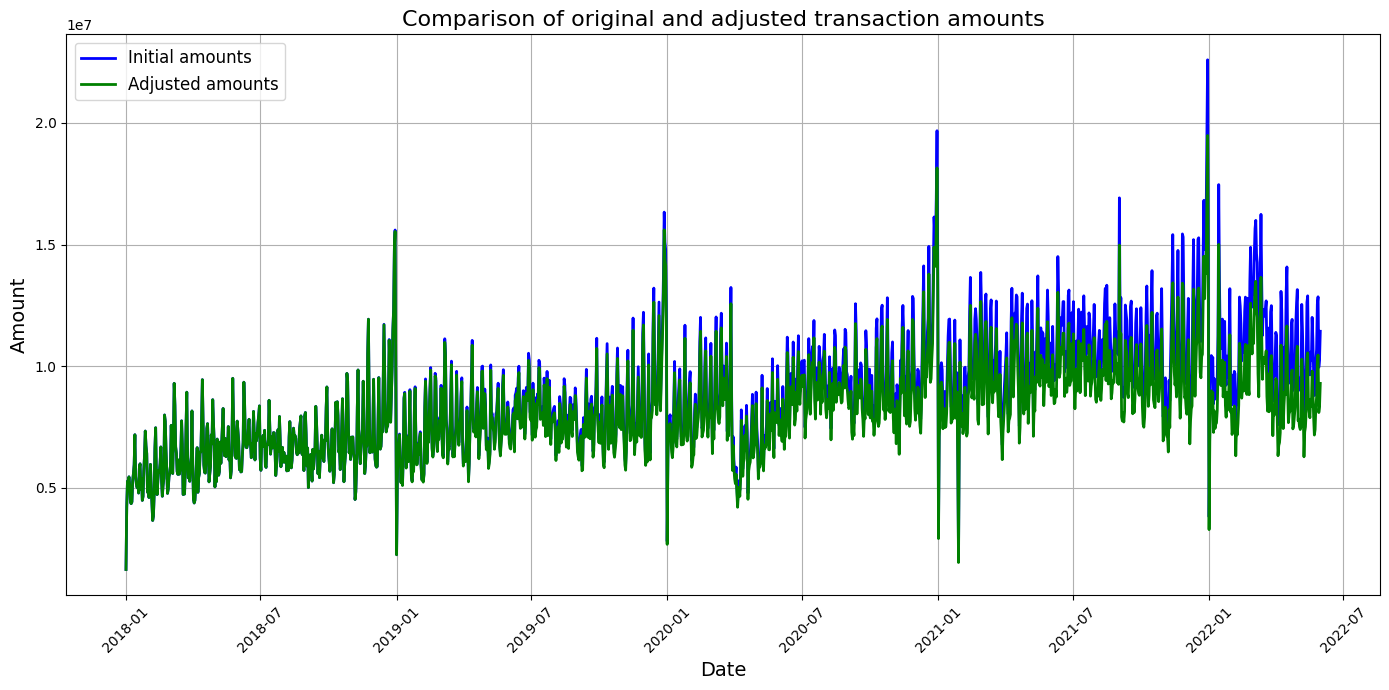

In [10]:
# Comparison of original and adjusted transaction amounts without inflation
original_totals = df.groupby('date')['amt'].sum().reset_index()
adjusted_totals = df.groupby('date')['adjusted_amt'].sum().reset_index()

plt.figure(figsize=(14, 7))

plt.plot(original_totals['date'], original_totals['amt'], label='Initial amounts', color='blue', linewidth=2)
plt.plot(adjusted_totals['date'], adjusted_totals['adjusted_amt'], label='Adjusted amounts', color='green', linewidth=2)

plt.xlabel('Date', fontsize=14)
plt.ylabel('Amount', fontsize=14)
plt.title('Comparison of original and adjusted transaction amounts', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
# Daily Aggregate Sum
ts = df.groupby('date')['adjusted_amt'].sum()

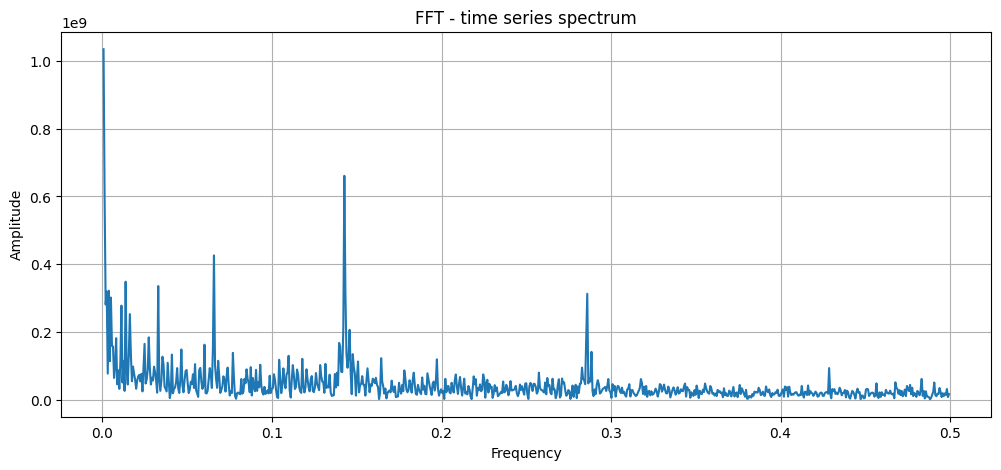

In [12]:
# FFT
n = len(ts)
ts_values = ts.values - np.nanmean(ts.values)
yf = fft(ts_values)
xf = fftfreq(n, d=1)  # d=1 — step in days

plt.figure(figsize=(12, 5))
plt.plot(xf[1:n//2], np.abs(yf[1:n//2]))
plt.title("FFT - time series spectrum")
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

<Figure size 1200x800 with 0 Axes>

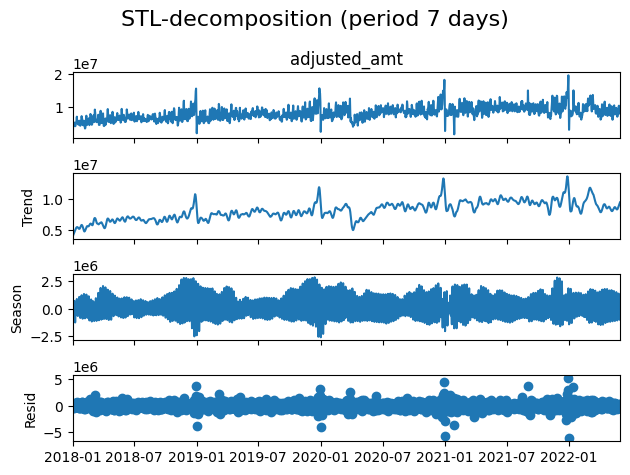

<Figure size 1200x800 with 0 Axes>

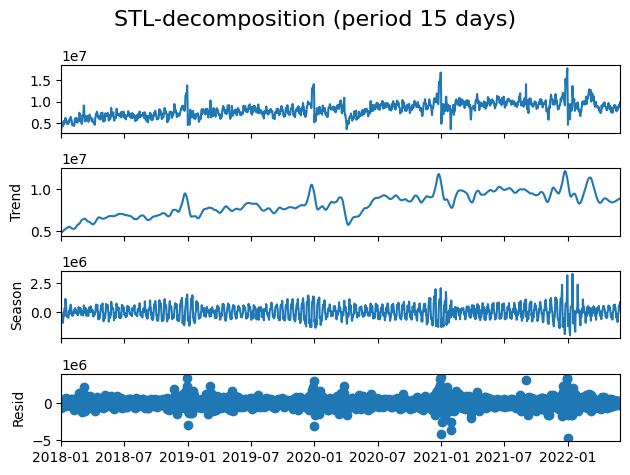

<Figure size 1200x800 with 0 Axes>

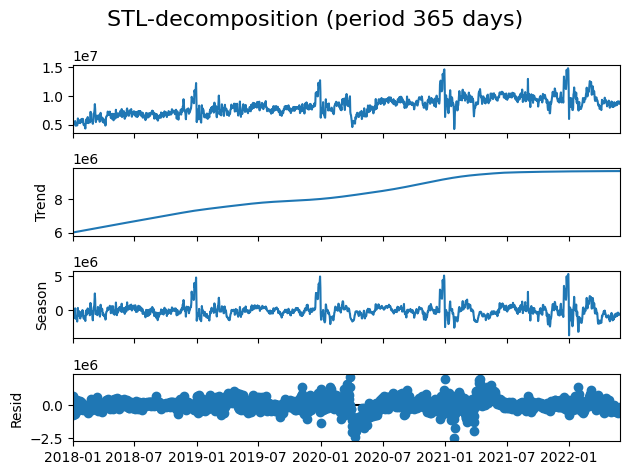

In [13]:
# STL-decomposition
current_ts = ts.copy()

# Sequential removal of seasonality
for i, period in enumerate([7,15,365]):
    stl = STL(current_ts, period=period)
    res = stl.fit()
    
    # Visualisation
    plt.figure(figsize=(12, 8))
    res.plot()
    plt.suptitle(f"STL-decomposition (period {period} days)", fontsize=16)
    plt.tight_layout()
    plt.show()
    
    deseasonalized_ts = current_ts - res.seasonal
    current_ts = deseasonalized_ts

In [14]:
# Combining adjusted amounts with original data
deseasonalized_ts.index = pd.to_datetime(deseasonalized_ts.index)

df['daily_share'] = df.groupby(df['date'].dt.date)['adjusted_amt'].transform(lambda x: x / x.sum())
df = df.merge(deseasonalized_ts.rename('deseasonalized_daily_total'), left_on='date', right_index=True,suffixes=('_left', '_right'))
df['adjusted_amount'] = df['daily_share'] * df['deseasonalized_daily_total']

# Checking the results
print("\nDataFrame with adjusted amounts:")
print(df[['date', 'adjusted_amt', 'adjusted_amount']].head())


DataFrame with adjusted amounts:
        date  adjusted_amt  adjusted_amount
0 2018-01-01         878.0      3556.224573
1 2018-01-01         249.0      1008.542049
2 2018-01-01          50.0       202.518484
3 2018-01-01        2564.0     10385.147841
4 2018-01-01         464.9      1883.016861


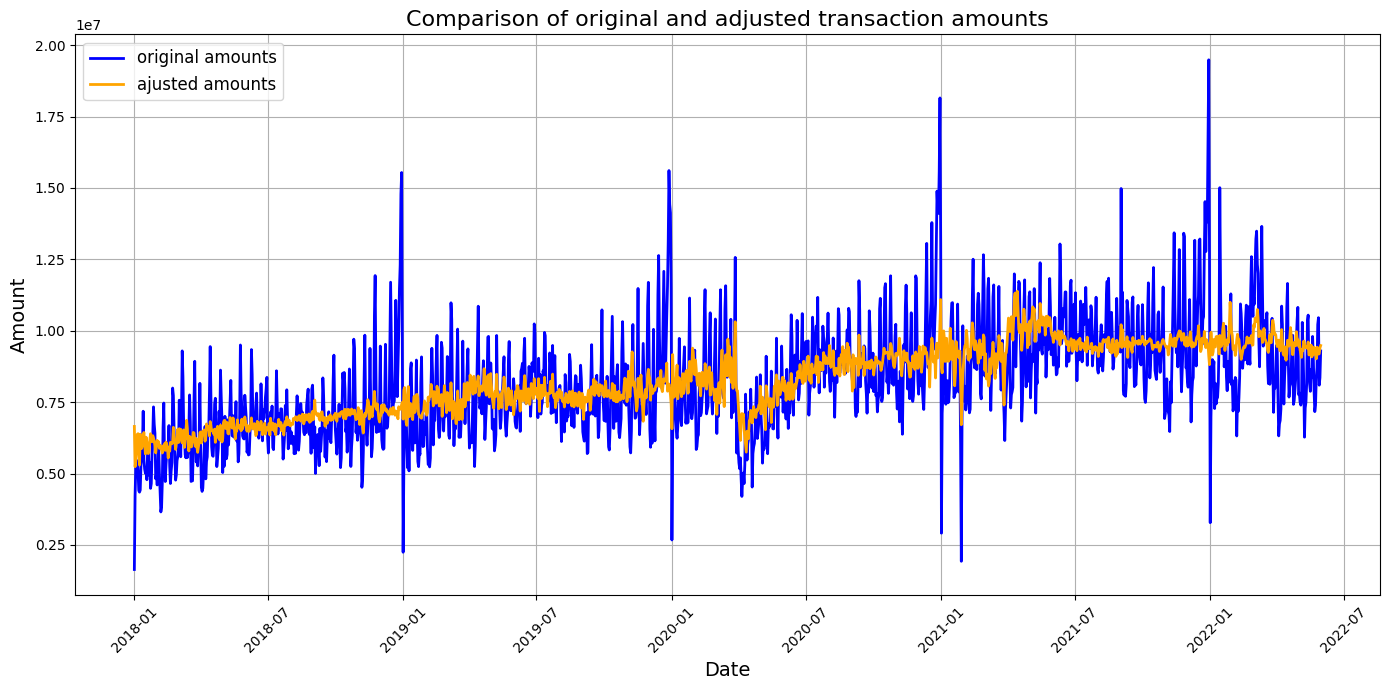

In [15]:
# Plotting a comparison graph
original_totals = df.groupby('date')['adjusted_amt'].sum().reset_index()
corrected_totals = df.groupby('date')['adjusted_amount'].sum().reset_index()

plt.figure(figsize=(14, 7))
plt.plot(original_totals['date'], original_totals['adjusted_amt'], label='original amounts', color='blue', linewidth=2)
plt.plot(corrected_totals['date'], corrected_totals['adjusted_amount'], label='ajusted amounts', color='orange', linewidth=2)

plt.xlabel('Date', fontsize=14)
plt.ylabel('Amount', fontsize=14)
plt.title('Сomparison of original and adjusted transaction amounts', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Compute consumer activity metric

In [16]:
# Client state
# Recount log10(amt_adjusted)
df['exp'] = np.log10(df[['adjusted_amount']])

# 2. Preparation of aggregated data
# Group by ['date', 'client', 'value'] and calculate the maximum exp value
individual = (df.groupby(['date', 'client', 'value'])['exp'].max().unstack(level='value', fill_value=0))

print("Client state by day:")
print(individual.head())

Client state by day:
value              self_realization  socialization  survival
date       client                                           
2018-01-01 3845            0.000000       3.084616  3.776287
           5044            0.000000       0.000000  4.411634
           6908            0.000000       0.000000  3.151563
           8332            2.835381       0.000000  2.426380
           12014           2.906348       0.000000  0.000000


# Model definition and fitting

In [17]:
individual = individual.reset_index()

In [18]:
individual.head()

value,date,client,self_realization,socialization,survival
0,2018-01-01,3845,0.000000,3.084616,3.776287
1,2018-01-01,5044,0.000000,0.000000,4.411634
2,2018-01-01,6908,0.000000,0.000000,3.151563
3,2018-01-01,8332,2.835381,0.000000,2.426380
4,2018-01-01,12014,2.906348,0.000000,0.000000


In [19]:
model_type = 'modified'

In [20]:
alldates=pd.DataFrame({'date':individual['date'].unique()})

In [21]:
individual = individual.set_index(['date', 'client'])

In [22]:
# Finding distribution parameters for all dates in a dataset
results = []
for idx, date in enumerate(alldates['date']):
    try:
        results_df = calc_distr_params(individual, date, 'modified')
        if not results_df.empty:
            results.append(results_df)
    except Exception as e:
        print(f"Error while processing {date}: {e}")

# Combine all results into one DataFrame
final_results = pd.concat(results, ignore_index=True)
print(final_results)

           date         B      beta        x0      alpha method  ks_statistic  \
0    2018-01-01  0.000001  0.503485  1.586148   3.261747    mle      0.200000   
1    2018-01-01  0.000001  1.201496  0.417312  20.570528    mls      0.366667   
2    2018-01-02  0.000001  0.412713  1.230158   2.467353    mle      0.200000   
3    2018-01-02  0.224856  0.776473  1.475937   3.029480    mls      0.333333   
4    2018-01-03  0.000001  0.400214  0.980063   3.056870    mle      0.200000   
...         ...       ...       ...       ...        ...    ...           ...   
3219 2022-05-29  0.164018  0.483261  1.538769   1.770002    mls      0.233333   
3220 2022-05-30  0.000001  0.352663  0.870557   2.698321    mle      0.133333   
3221 2022-05-30  0.100047  0.503175  1.050131   3.048328    mls      0.233333   
3222 2022-05-31  0.100000  0.361328  0.770605   3.039944    mle      0.166667   
3223 2022-05-31  0.028008  0.519377  0.630981   4.901398    mls      0.166667   

       p_value  wasserstein

In [23]:
final_results.head()

,date,B,beta,x0,alpha,method,ks_statistic,p_value,wasserstein_distance,rmse
0,2018-01-01,0.000001,0.503485,1.586148,3.261747,mle,0.200000,0.594071,0.016032,0.053532
1,2018-01-01,0.000001,1.201496,0.417312,20.570528,mls,0.366667,0.034580,0.006530,0.007793
2,2018-01-02,0.000001,0.412713,1.230158,2.467353,mle,0.200000,0.594071,0.013524,0.055110
3,2018-01-02,0.224856,0.776473,1.475937,3.029480,mls,0.333333,0.070888,0.008399,0.010100
4,2018-01-03,0.000001,0.400214,0.980063,3.056870,mle,0.200000,0.594071,0.014936,0.053256


In [24]:
final_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3224 entries, 0 to 3223
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  3224 non-null   datetime64[ns]
 1   B                     3224 non-null   float64       
 2   beta                  3224 non-null   float64       
 3   x0                    3224 non-null   float64       
 4   alpha                 3224 non-null   float64       
 5   method                3224 non-null   object        
 6   ks_statistic          3224 non-null   float64       
 7   p_value               3224 non-null   float64       
 8   wasserstein_distance  3224 non-null   float64       
 9   rmse                  3224 non-null   float64       
dtypes: datetime64[ns](1), float64(8), object(1)
memory usage: 252.0+ KB


In [25]:
summary = analyze_results(final_results)

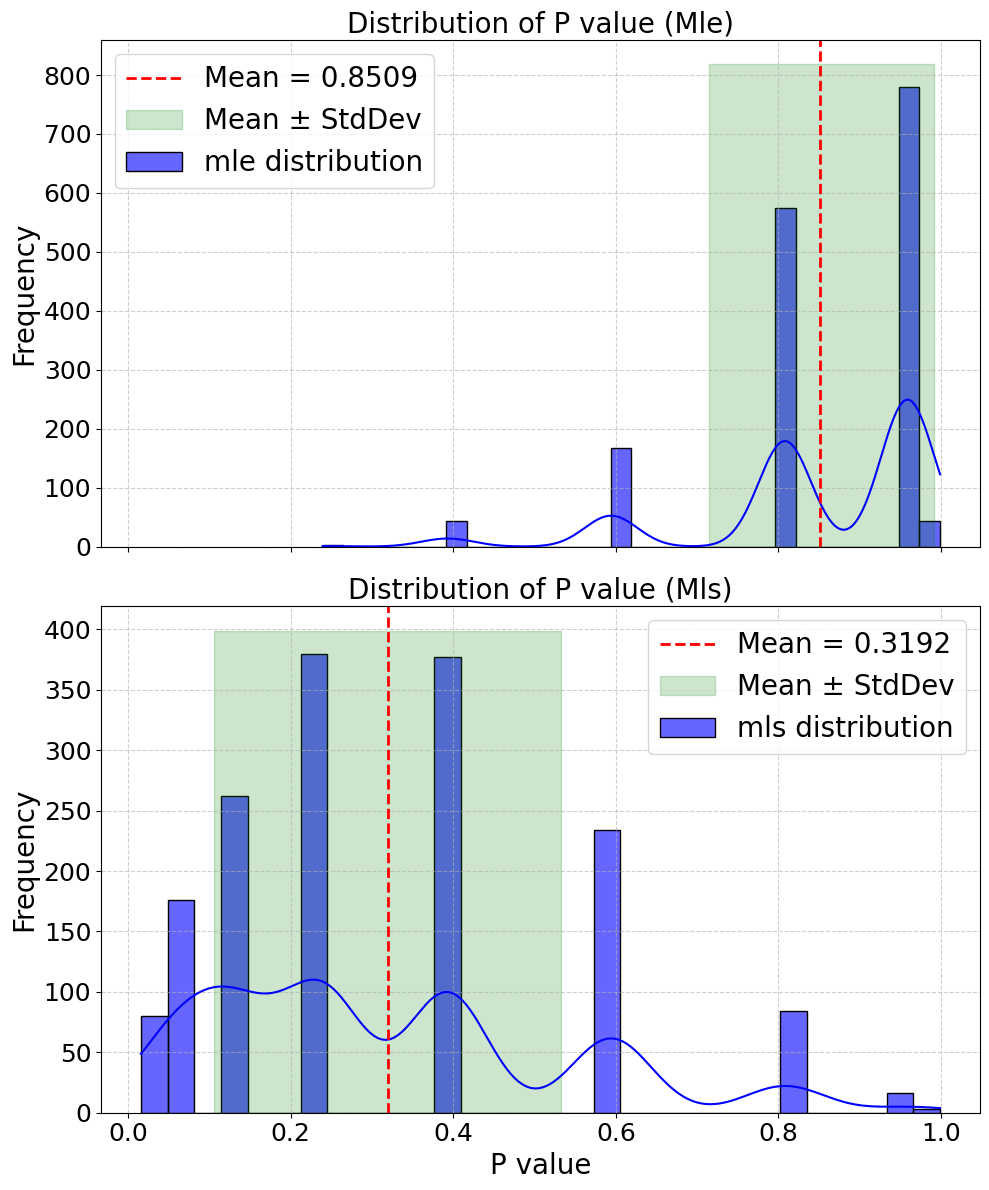

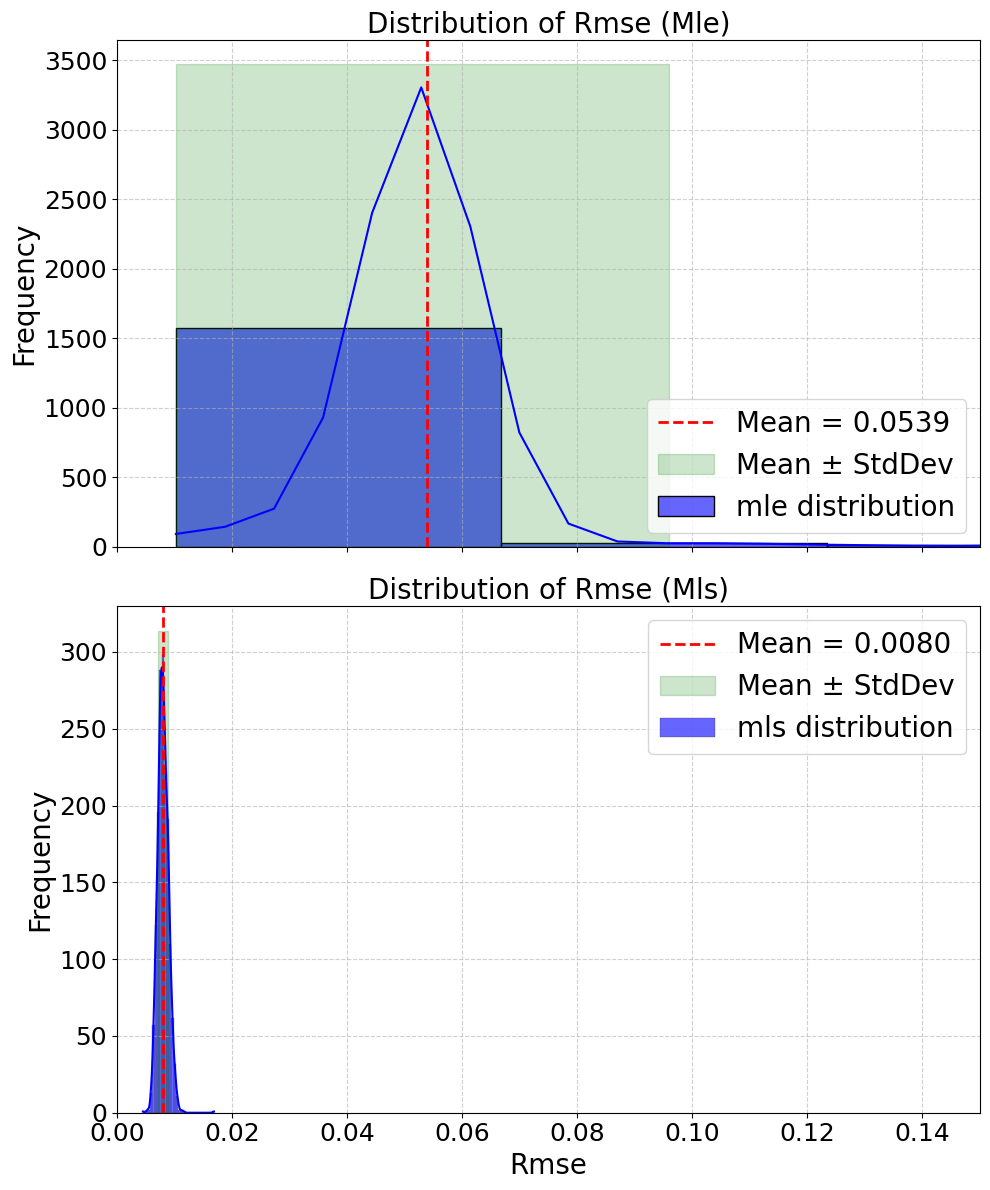

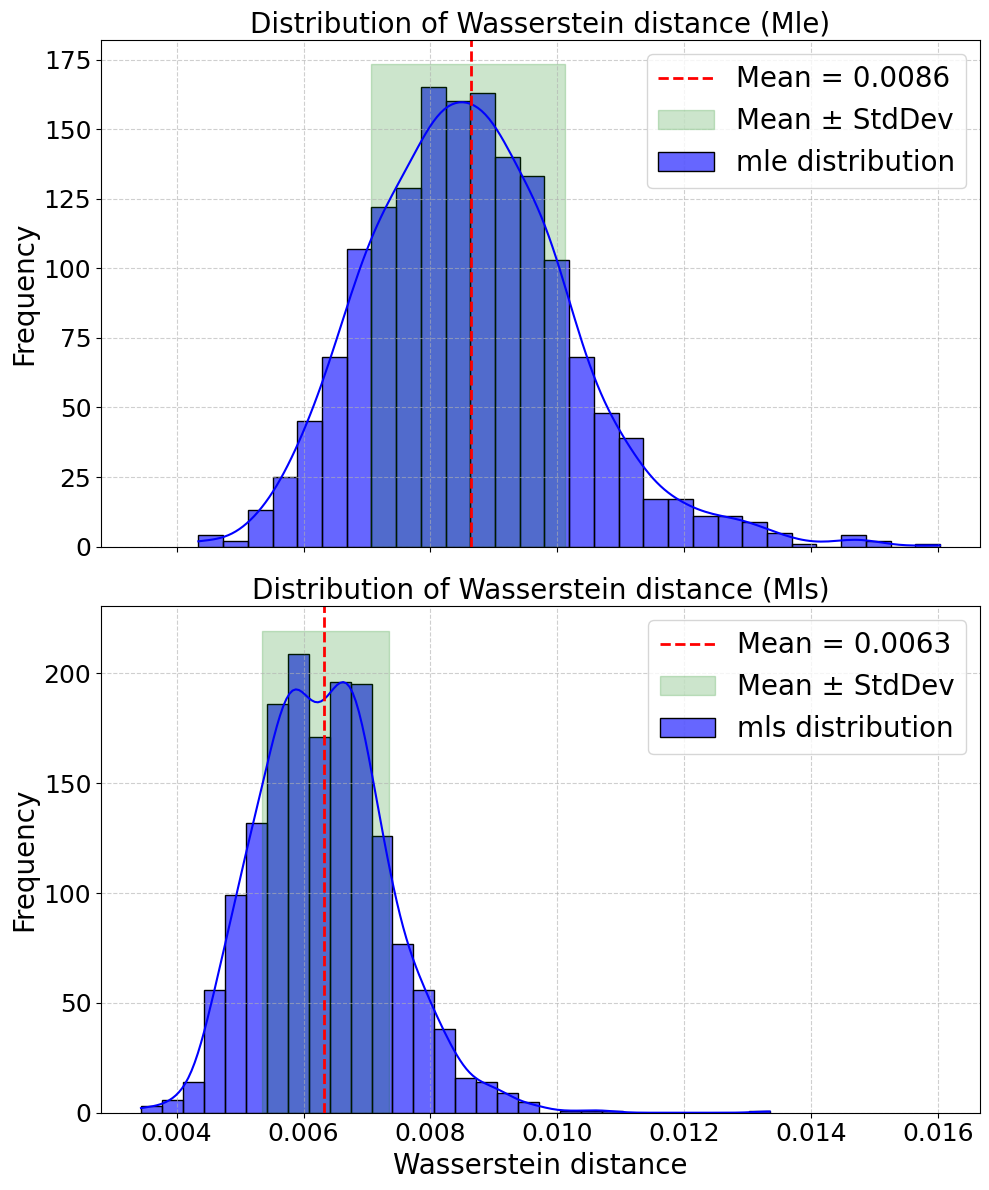

In [26]:
plot_metric_distributions(final_results)

# Modeling results for low and high active consumers 

In [27]:
# List of dates for analysis
dates = ["2018-08-15", "2021-12-21"]

In [28]:
results = []

for date in dates:
    result_df = calc_distr_params(individual, date, model_type='modified')
    if result_df.empty:
        print(f"No data available for {date}. Skipping...")
        continue
    
    mle_params = result_df[result_df['method'] == 'mle'].iloc[0][['B', 'beta', 'x0', 'alpha']].values
    mls_params = result_df[result_df['method'] == 'mls'].iloc[0][['B', 'beta', 'x0', 'alpha']].values
    
    try:
        data = individual.loc[date]
        b = data.apply(lambda x: consumer_acticity(x), axis=1)
        b = b.value_counts(bins=30, normalize=True)
        x_data = np.array([(edge.left + edge.right) / 2 for edge in b.index])
        y_data = np.array(b.values)
        y_data = y_data / np.sum(y_data)
    except Exception as e:
        print(f"Error processing data for {date}: {e}")
        continue
    
    x = np.linspace(0, 6, 1000)
    y_fit_mle = mod_maxwell_boltzmann(x, *mle_params)
    y_fit_mls = mod_maxwell_boltzmann(x, *mls_params)
    
    y_fit_mle = normalize_curve(y_fit_mle, y_data)
    y_fit_mls = normalize_curve(y_fit_mls, y_data)
    
    results.append({
        'date': date,
        'x_data': x_data,
        'y_data': y_data,
        'y_fit_mle': y_fit_mle,
        'y_fit_mls': y_fit_mls,
        'mle_params': mle_params,
        'mls_params': mls_params
    })

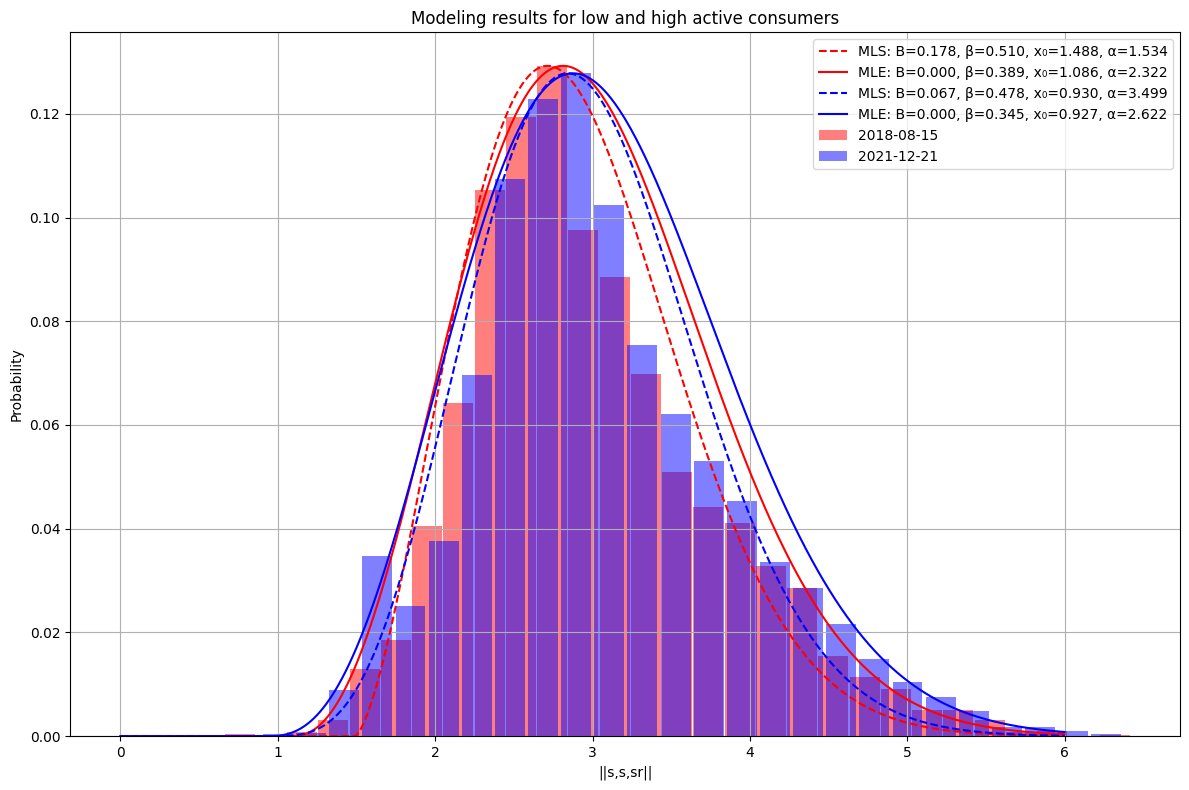

In [29]:
# Plotting a graph
plt.figure(figsize=(12, 8))

for i, res in enumerate(results):
    date = res['date']
    x_data = res['x_data']
    y_data = res['y_data']
    y_fit_mle = res['y_fit_mle']
    y_fit_mls = res['y_fit_mls']
    mle_params = res['mle_params']
    mls_params = res['mls_params']
    if i == 0:
        color = 'red'
    else:
        color = 'blue'
    plt.bar(x_data, y_data, width=0.19, color=color, alpha=0.5, label=f'{date}')
    plt.plot(x, y_fit_mls, ls='--', color=color, label=f'MLS: B={mls_params[0]:.3f}, β={mls_params[1]:.3f}, x₀={mls_params[2]:.3f}, α={mls_params[3]:.3f}')
    plt.plot(x, y_fit_mle, ls='-', color=color, label=f'MLE: B={mle_params[0]:.3f}, β={mle_params[1]:.3f}, x₀={mle_params[2]:.3f}, α={mle_params[3]:.3f}')

plt.xlabel('||s,s,sr||')
plt.ylabel('Probability')
plt.title('Modeling results for low and high active consumers')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

#  Comparison of the modified and classical Maxwell-Boltzmann distribution

In [30]:
date_to_plot = '2021-12-21'

In [31]:
data = individual.loc[date_to_plot]
activity = data.apply(consumer_acticity, axis=1)
hist_data = activity.value_counts(bins=30, normalize=True)
x_data = np.array([(edge.left + edge.right) / 2 for edge in hist_data.index])
y_data = np.array(hist_data.values)

In [32]:
params_mod = fit_methods(x_data, y_data, method='mls', model_type='modified')
params_cls = fit_methods(x_data, y_data, method='mls', model_type='classical')

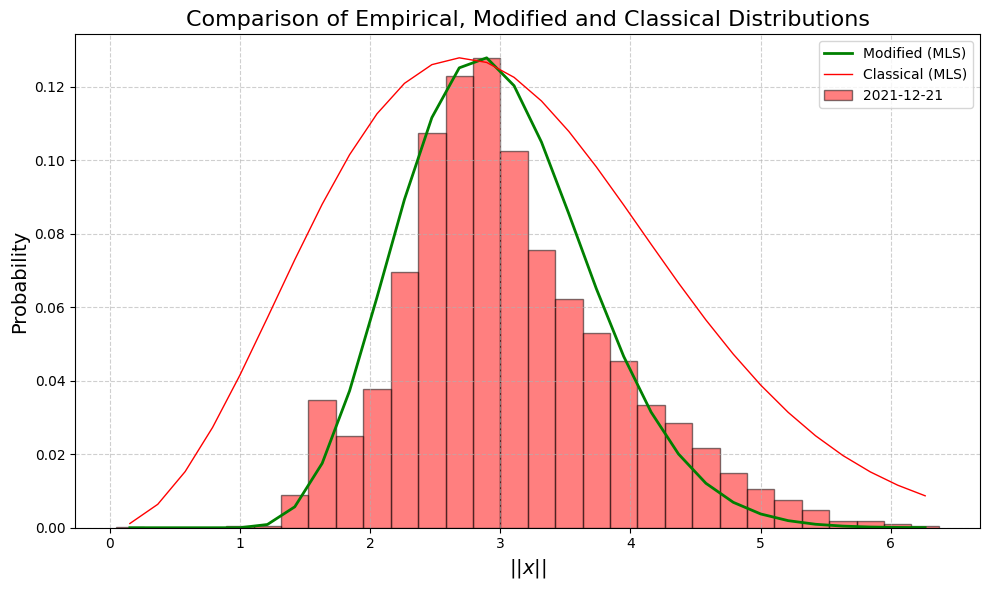

In [33]:
# Visualisation
y_fit_mod = mod_maxwell_boltzmann(x_data, *params_mod)
y_fit_mod = normalize_curve(y_fit_mod, y_data)

y_fit_cls = clas_maxwell_boltzmann(x_data, *params_cls)
y_fit_cls = normalize_curve(y_fit_cls, y_data)

sorted_idx = np.argsort(x_data)
x_sorted = x_data[sorted_idx]
y_fit_mod_sorted = y_fit_mod[sorted_idx]
y_fit_cls_sorted = y_fit_cls[sorted_idx]

plt.figure(figsize=(10, 6))
plt.bar(x_data, y_data, width=(x_data[1] - x_data[0]), alpha=0.5, color='red', label=f'{date_to_plot}', edgecolor='black')
plt.plot(x_sorted, y_fit_mod_sorted, color='green', linestyle='-', label='Modified (MLS)', linewidth=2)
plt.plot(x_sorted, y_fit_cls_sorted, color='red', linestyle='-', label='Classical (MLS)', linewidth=1)
plt.xlabel(r"$||x||$", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.title("Comparison of Empirical, Modified and Classical Distributions", fontsize=16)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [34]:
# Results for all data
results = []
for idx, date in enumerate(alldates['date']):
    try:
        results_df = calc_distr_params(individual, date, 'classical')
        if not results_df.empty:
            results.append(results_df)
    except Exception as e:
        print(f"Error while processing {date}: {e}")

cls_results = pd.concat(results, ignore_index=True)
print(cls_results)

           date         B      beta    x0 alpha method  ks_statistic  \
0    2018-01-01  0.100000  0.114747  None  None    mle      0.600000   
1    2018-01-01  0.016466  0.103927  None  None    mls      0.666667   
2    2018-01-02  0.100000  0.141492  None  None    mle      0.433333   
3    2018-01-02  0.027419  0.132304  None  None    mls      0.466667   
4    2018-01-03  0.100000  0.148523  None  None    mle      0.400000   
...         ...       ...       ...   ...   ...    ...           ...   
3219 2022-05-29  0.026792  0.129670  None  None    mls      0.366667   
3220 2022-05-30  0.100000  0.153270  None  None    mle      0.333333   
3221 2022-05-30  0.030607  0.141631  None  None    mls      0.366667   
3222 2022-05-31  0.100000  0.157496  None  None    mle      0.333333   
3223 2022-05-31  0.028510  0.143752  None  None    mls      0.366667   

       p_value  wasserstein_distance      rmse  
0     0.000024              0.058191  0.185917  
1     0.000001              0.062390 

In [35]:
print(analyze_results(cls_results))

  method  ks_statistic_mean  ks_statistic_std  p_value_mean  p_value_std  \
0    mle           0.373118          0.032944      0.037139     0.027518   
1    mls           0.396857          0.032523      0.021433     0.015350   

   wasserstein_distance_mean  wasserstein_distance_std  rmse_mean  rmse_std  \
0                   0.031620                  0.004168   0.105066  0.011370   
1                   0.033866                  0.004312   0.023146  0.002271   

   ks_statistic_variation  p_value_variation  wasserstein_distance_variation  \
0                0.088294           0.740949                        0.131813   
1                0.081953           0.716211                        0.127331   

   rmse_variation  
0        0.108221  
1        0.098137  
